In [3]:
import requests  # for using API
import xml.etree.ElementTree as ET  # for parsing XML
import numpy as np  # for using pandas
import pandas as pd  # for using dataframes
import json
from bs4 import BeautifulSoup
from pathlib import Path  
from datetime import datetime
import time
from tqdm.notebook import tqdm
import json
import re
import spacy
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
apikey = 'f041ba46e2ded3d862c9da57dcabb707'
def construct_request(startpos, apikey, decade):
    # construct limits using decade as template literal
    limits = '{"advcategory":["Article","Detailed Lists, Results, Guides","Editorial","Literature","News","Letters","Arts And Culture","Commerce And Business","Reviews"],"decade":["' + decade + '"],"date.from":["1850-01-01"],"date.to":["1949-12-31"]}'
    url = 'https://trove.nla.gov.au/api/search/137'
    headers = {
        'accept': 'application/json, text/plain, */*',
        'apikey': apikey, # this api key is changed daily and need to be obtained from the network panel in Chrome dev tools. It cannot be replaced with user's api key.
        'referer': 'https://trove.nla.gov.au/'
    }
    params = {
        'terms': '(chinese recipe) AND (ingredient OR cup OR tablespoon OR teaspoon OR salt OR sugar OR tsp OR tbsp) -(longevity)',
        'limits': limits,
        'startPos': startpos,
        'pageSize': 100
    }
    return url, headers, params

data_list = []
for j in tqdm(range (185, 195)):
    for i in tqdm(range(0, 25)):
        url, headers, params = construct_request(i*100, apikey, str(j))
        response = requests.get(url, headers=headers, params=params)
        try:
            data = response.json() 
        except Exception as e:
            print(response.status_code)
            print(response.text)
            break
        finally:
            data_list.append(data)
            if data['hasMoreResults'] == False:
                break
        
        

In [ ]:
# Serializing json
data_object = {"data": data_list}
json_object = json.dumps(data_object, indent=4)
 
# Writing to sample.json
with open("full-newspaper-data-chinese-recipe-not-longevity-with-recipe-keywords.json", "w") as outfile:
    outfile.write(json_object)

In [ ]:
df_list = []
for data in data_list:
    df_list.append(pd.DataFrame(data['works']))

combined_df = pd.concat(df_list)
filepath = Path('full-newspaper-data-chinese-recipe-not-longevity-with-recipe-keywords.csv')
combined_df.to_csv(filepath)

In [158]:
combined_df.columns

Index(['id', 'workAnnotationLabel', 'annotatedId', 'title', 'formatDisplay',
       'format', 'mainFormat', 'numFormats', 'itemMedia', 'itemFormats',
       'topItemFormats', 'primaryFormat', 'description', 'yearRange',
       'snippets', 'author', 'authors', 'workType', 'thumbnailUrl',
       'thumbnailIsCulturallySensitive', 'numItems', 'numHoldings',
       'onlineUrl', 'onlineText', 'languages', 'austLanguages',
       'firstArticlePublicationName', 'culturallySensitive',
       'firstAustraliansInd', 'correctableText', 'newspaper', 'abstrct',
       'date', 'page', 'numberOfCorrectors', 'correctedByMe', 'wordCount',
       'articleType', 'illustrated'],
      dtype='object')

In [160]:
filtered_metadata = pd.read_csv('full-newspaper-data-chinese-recipe-not-longevity-with-recipe-keywords.csv')[['id','title', 'abstrct', 'snippets', 'formatDisplay', 'newspaper', 'date', 'yearRange', 'articleType', 'wordCount', 'onlineUrl', 'description', 'illustrated']]
print(len(filtered_metadata.index), 'metadata entries loaded')

8569 metadata entries loaded


In [166]:

tqdm.pandas()
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS 

def clean_text(text):
    #remove <em> and </em> tags
    text = re.sub(r'<em>', '', text)
    text = re.sub(r'</em>', '', text)
    
    text = re.sub(r'-(?=\s)', '', text) # Dehyphenate words split across 2 lines
    text = text.lower()  # Lowercase text
    text = re.sub(r"[^\w\s]", '', text)  # Remove punctuation
    # text = nltk.word_tokenize(text)  # Tokenize text
    text = nlp(text)
    text = [token for token in text if not token.is_stop] 
    text = ' '.join([token.lemma_ for token in text])
    return text

filtered_metadata.fillna({'snippets': ' ', 'abstrct': ' '}, inplace=True)
filtered_metadata['cleanedAbstract'] = filtered_metadata['abstrct'].progress_apply(clean_text)
filtered_metadata['cleanedSnip'] = filtered_metadata['snippets'].progress_apply(clean_text)

  0%|          | 0/8569 [00:00<?, ?it/s]

  0%|          | 0/8569 [00:00<?, ?it/s]

In [167]:
filepath = Path('cleaned-full-newspaper-data-chinese-recipe-not-longevity-with-recipe-keywords.csv')
filtered_metadata.to_csv(filepath)

In [168]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [228]:
data = pd.read_csv('cleaned-full-newspaper-data-chinese-recipe-not-longevity-with-recipe-keywords.csv')
data['cleanedTitle'] = data['title'].progress_apply(clean_text)
data['combined_text'] = data['cleanedAbstract'] + " " + data['cleanedSnip'] + " " + data['title']
data['combined_text'].fillna("", inplace=True)

# Apply TF-IDF on the combined text
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(data['combined_text'])

# Remove duplicates based on the combined_text column
data_deduplicated = data.drop_duplicates(subset='combined_text')

# Apply TF-IDF on the deduplicated combined text
tfidf_matrix_deduplicated = tfidf_vectorizer.transform(data_deduplicated['combined_text'])

  0%|          | 0/8569 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

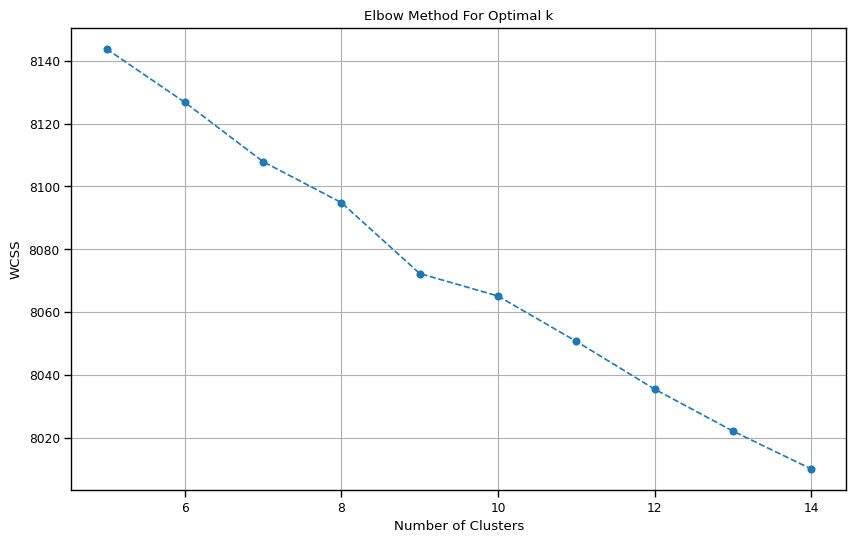

In [230]:
wcss = []  # within-cluster sum of squares
k_values = range(5, 15)

for k in tqdm(k_values):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix_deduplicated)
    wcss.append(kmeans.inertia_)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, wcss, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [232]:
# Apply KMeans clustering on the deduplicated data
num_clusters = 9
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
data_deduplicated['cluster'] = kmeans.fit_predict(tfidf_matrix_deduplicated)

/var/folders/6l/__m_t5fn1zqgbdwzg0by22400000gn/T/ipykernel_15734/2383424026.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_deduplicated['cluster'] = kmeans.fit_predict(tfidf_matrix_deduplicated)


In [233]:
from collections import Counter
import numpy as np

def top_words_in_cluster(cluster_data, vectorizer, tfidf_matrix, n=10):
    # Adjust the indices to match the shape of the tfidf_matrix
    indices = np.where(data_deduplicated.index.isin(cluster_data.index))[0]
    
    # Sum the tf-idf values for each term in the cluster
    word_sum = np.sum(tfidf_matrix[indices].toarray(), axis=0)
    
    # Get the terms and their respective indices from the vectorizer
    terms = np.array(vectorizer.get_feature_names_out())
    
    # Get the indices that would sort the word_sum array
    sorted_indices = word_sum.argsort()[::-1]
    
    # Extract the top n terms using the sorted indices
    top_n_terms = terms[sorted_indices][:n]
    
    return top_n_terms

# Get the top 10 words for each cluster
top_words = {}
for cluster in range(num_clusters):
    cluster_data = data_deduplicated[data_deduplicated['cluster'] == cluster]
    top_words[cluster] = top_words_in_cluster(cluster_data, tfidf_vectorizer, tfidf_matrix_deduplicated)

print(top_words)

{0: array(['chine', 'crepe', 'de', 'frock', 'dress', 'white', 'wear', 'black',
       'silk', 'woman'], dtype=object), 1: array(['sugar', 'salt', 'oz', 'teaspoonful', 'water', 'add',
       'tablespoonful', 'half', 'butter', 'egg'], dtype=object), 2: array(['recipe', 'the', 'chin', 'salt', 'cup', 'sugar', 'water', 'and',
       'good', 'to'], dtype=object), 3: array(['cup', 'teaspoon', 'tablespoon', 'sugar', 'flour', 'butter',
       'salt', 'egg', 'milk', 'woman'], dtype=object), 4: array(['untold', 'outing', 'writesmy', 'agony', 'positively', 'wind',
       'affect', 'threaten', 'noticeably', 'cheaper'], dtype=object), 5: array(['question', 'answer', 'answers', 'housewife', 'questions',
       'column', 'page', 'relate', 'correspondents', 'editor'],
      dtype=object), 6: array(['personal', 'and', 'social', 'whirl', 'the', 'page', 'section',
       'pars', 'prominent', 'household'], dtype=object), 7: array(['cupful', 'women', 'teaspoonful', 'sugar', 'to', 'tablespoonful',
       'ha

In [235]:
# Filter out entries from the selected clusters that don't contain the specified keywords in the 'cleanedSnip' field
selected_clusters = [1,2,3,7]
keywords = ['chinese', 'china']
filtered_data = data_deduplicated[data_deduplicated['cluster'].isin(selected_clusters)]
filtered_data = filtered_data[filtered_data['cleanedSnip'].str.contains('|'.join(keywords), case=False, na=False)]
filtered_data.to_csv('filtered-7clusters-cleaned-newspaper-data-chinese-recipe-not-longevity-with-recipe-keywords.csv')
# Display the distribution of the filtered entries among the selected clusters
filtered_cluster_distribution = filtered_data['cluster'].value_counts().sort_index()
print(filtered_cluster_distribution)

cluster
1     72
2    134
3     38
7      6
Name: count, dtype: int64


In [86]:
def extract_text(id):
    html_doc = requests.get('https://trove.nla.gov.au/newspaper/article/' + str(id))
    soup = BeautifulSoup(html_doc.text, 'html.parser')
    form_element = soup.select_one('#fulltextContents > form')
    scroll_text = form_element.find('div', class_=['alert', 'sr-only'])
    if scroll_text is not None:
        form_element.find('div', class_=['alert', 'sr-only']).decompose()
    # Extract the inner text of the 'form' element
    inner_text = form_element.get_text(separator=' ', strip=True)
    return inner_text

In [237]:
tqdm.pandas()

# Define a function to split data into batches
def split_into_batches(data, batch_size):
    return [data[i:i + batch_size] for i in range(0, len(data), batch_size)]

# Split IDs into batches of 100
id_batches = split_into_batches(filtered_data['id'], 100)

# Loop through each batch and apply the function
for batch in tqdm(id_batches):
    filtered_data.loc[batch.index, 'text'] = batch.progress_apply(extract_text)
    time.sleep(10)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [238]:
filtered_data['cleanedText'] = filtered_data['text'].progress_apply(clean_text)

  0%|          | 0/250 [00:00<?, ?it/s]

In [248]:
filtered_data['year'] = pd.to_datetime(filtered_data['date']).dt.year
filtered_data.to_csv('filtered-9clusters-newspaper-full.csv')

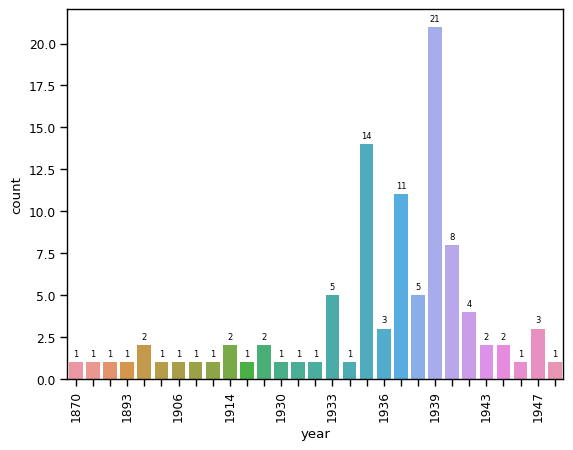

In [257]:
sns.set_context('paper')
ax = sns.countplot(x = 'year', data = selected_rows.sort_values(by=['year']))
plt.xticks(rotation=90)
for ind, label in enumerate(plt.gca().get_xticklabels()):
    if ind % 3 == 0:  # show every 20th label
        label.set_visible(True)
    else:
        label.set_visible(False)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 6), 
                textcoords='offset points',
                fontsize=6)
plt.show()

In [255]:
selected_indices = [191, 446, 1189, 1289, 1371, 1511, 1796, 1873, 1970,2778, 2801, 2975, 3261, 3992, 4061, 5751, 5759, 5776, 5781, 5799, 5809,5828, 5858,5868,5879, 5894, 5905, 5936, 5981,5989, 6014, 6023, 6034, 6054, 6065, 6087, 6097, 6099, 6100, 6101, 6102, 6103, 6104, 6105, 6106, 6108, 6109, 6123, 6143, 6160, 6176, 6190, 6198, 6206, 6216, 6218, 6220, 6277, 6307, 6309, 6311, 6316, 6317, 6325, 6330, 6336, 6401, 6409, 6449, 6473, 6481, 6624, 6629, 6630, 6636, 6701, 6862, 6867, 7850, 7854, 7855, 7857, 7858, 7867, 7881, 7882, 7921, 7927, 7929, 7933, 7971, 7972, 8022, 8034, 8065, 8069, 8136, 8184, 8236]
selected_rows = filtered_data.loc[selected_indices]

In [258]:
selected_rows.to_csv('manually-selected-newspaper-chinese-recipes.csv')

In [196]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [199]:
# Vectorize the 'cleanedText' column using TF-IDF
tfidf_vectorizer_reloaded = TfidfVectorizer(stop_words='english')
data_tfidf_reloaded = tfidf_vectorizer_reloaded.fit_transform(filtered_data['cleanedText'].fillna(''))


In [202]:
def print_top_words(model, feature_names, n_top_words=15):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        topics.append(message)
    return topics

In [219]:
# Train the LDA model with 15 topics on the vectorized data
lda_model_15_topics_reloaded = LatentDirichletAllocation(n_components=15, random_state=42)
lda_model_15_topics_reloaded.fit(data_tfidf_reloaded)
topics_15_reloaded = print_top_words(lda_model_15_topics_reloaded, tfidf_vectorizer_reloaded.get_feature_names_out())
topics_15_reloaded

['Topic #0: lefevre marty cornerite curriestreet hoarfrost alabama kearsarge wholemeal gryst etty sturtstreet tainable apocryphal francatelli phial',
 'Topic #1: goulter patt jeanette tootsicum alvar rodeo jeffery czynski chintz panelling makee vestry saga tearoom cottager',
 'Topic #2: humus erosion indore hunting atoe shrewd acclimatize okhotsk 1734 dictionary sudan ural dic compost gaswork',
 'Topic #3: percival biggle jujube irwin rowlandson avhich manchoukuo vambery torquay malone kalgoorlie monk bonaparte www cobweb',
 'Topic #4: putee flou takee wimble tablesp tabus popover makeo bechedemer makee freer ayr unionism euroa curtin',
 'Topic #5: rodeo chilblain elgin weigall graftenreid cowgirl hangki ipiait gadd cheeso minter beta pankhurst disheshave rtstaurant',
 'Topic #6: liqu eur orangepeel communist cognac pinnaroo deadhead barometric zora communism mandarine anisette kummel corian paperbark',
 'Topic #7: noodle lichee petal tomatoflower rosepetal wuh mein cantonese cornstarc

In [225]:
filtered_data['cleanedTitle'] = filtered_data['title'].progress_apply(clean_text)

  0%|          | 0/1729 [00:00<?, ?it/s]

In [216]:
# Display the top documents based on the combined score
top_sorted_data_reloaded = sorted_data_reloaded.head(20)  # Displaying the top 20 as an example
top_sorted_data_reloaded[['cleanedSnip', 'combined_score']]

,cleanedSnip,combined_score
2742,househol au okery doronty chinese dalntlhsi as...,0.573966
7922,chinesel ho beei fe tilise soil sucessfully ...,0.570942
918,hiredfood loveeducated missrecipeb 74 past...,0.551552
969,s comet 1010 tho pitzroy dockarrival tho ...,0.542632
976,remindersiniprove went sugar macliiiirymango...,0.539580
5,duck chinese affray row tent saturday ik eur...,0.518713
7211,chinese temple obelisk desertot pun sugar fl...,0.498100
1594,ordor cookery recipe seasonable bo relied on...,0.490312
1775,light light cup milk yon dm cup flou meve ta...,0.486845
989,queen grauddaugliter household recipe 1...,0.486816


In [ ]:
filtered_data['text'] = filtered_metadata['id'].progress_apply(extract_text)
filtered_metadata['date'] = filtered_metadata['date'].apply(lambda x: datetime.strptime(x, '%A %d %B %Y').strftime('%d-%m-%Y'))

In [ ]:
filepath = Path('full-data_chinese_recipe-not-longevity-newspaper.csv')
filtered_metadata.to_csv(filepath)

In [ ]:
article_data = pd.read_csv('full-data_chinese_recipe-not-longevity-newspaper.csv')

In [ ]:
article_data['text'][0]

'CHINESE RECIPE Following an inquiry by D.F. (Mirboo North) for a recipe for dim sims, a man reader sends the following information:— Ingredients: Minced pork, or pork and fowl, chopped water chestnuts (obtain- able at any Chinese store). Method: Make small containers of thin boiling paste (or leaf macaroni if ob- tainable). Fill with mixture almost to the top, leave tops open. Steam until cooked.'

In [62]:
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS 

def clean_text(text):
    text = re.sub(r'(\w+-) ([a-z]\w+)', r'\1\2', text) # Dehyphenate words split across 2 lines
    text = text.lower()  # Lowercase text
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r"[^\w\s]", '', text)  # Remove punctuation
    # text = nltk.word_tokenize(text)  # Tokenize text
    text = nlp(text)
    text = [token for token in text if not token.is_stop] 
    text = ' '.join([token.lemma_ for token in text])
    return text

article_data['cleanedText'] = article_data['text'].apply(clean_text)

In [63]:
article_data['year'] =article_data['date'].str.split('-').str[2]

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

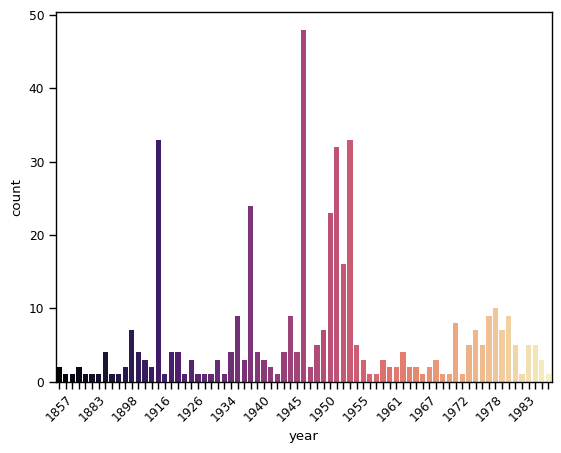

In [68]:
sns.set_context('paper')
sns.countplot(x = 'year', data = article_data.sort_values(by=['year']), palette = 'magma')
#plt.title("Count of Newspaper Articles on Women's Suffrage in South Australia from 17 to 19 December 1894", fontsize=13)
plt.xticks(rotation=45)
for ind, label in enumerate(plt.gca().get_xticklabels()):
    if ind % 5 == 0:  # show every 20th label
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.show()

In [71]:
top_10_years = article_data['year'].value_counts().head(10)

print(top_10_years)

year
1947    48
1954    33
1916    33
1952    32
1939    24
1951    23
1953    16
1979    10
1936     9
1945     9
Name: count, dtype: int64


## Magazine

In [77]:
apikey = '174821ad665a29b827963e9f1109b850'
def construct_request(startpos, apikey):
    url = 'https://trove.nla.gov.au/api/search/134'
    headers = {
        'accept': 'application/json, text/plain, */*',
        'apikey': apikey, # this api key is changed daily and need to be obtained from the network panel in Chrome dev tools. It cannot be replaced with user's api key.
        'referer': 'https://trove.nla.gov.au/'
    }
    params = {
        'terms': '(chinese recipe)',
        #'limits': '{"advArtType":["newspapers"]}',
        'startPos': startpos,
        'pageSize': 100
    }
    return url, headers, params

data_list = []
for i in range(0, 15):
    url, headers, params = construct_request(i*100, apikey)
    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    data_list.append(data)

In [78]:
df_list = []
for data in data_list:
    df_list.append(pd.DataFrame(data['works']))

combined_df = pd.concat(df_list)
# metadata = pd.DataFrame(data['works'])
filepath = Path('data_chinese_recipe-magazine.csv')
combined_df.to_csv(filepath)

In [79]:
len(combined_df)

1460

In [82]:
combined_df.iloc[0]

id                                                                        233181659
workAnnotationLabel                                                               s
annotatedId                                                              s233181659
title                               PRIZE RECIPE CHINESE CHUTNEY (14 December 1937)
formatDisplay                          Article; Article/Journal or magazine article
format                                 Article/Journal or magazine article; Article
mainFormat                                                                Monograph
numFormats                                                                        2
itemMedia                                                                        {}
itemFormats                       {'Article': 1, 'Article/Journal or magazine ar...
topItemFormats                         Article; Article/Journal or magazine article
primaryFormat                                                               

In [86]:
filtered_metadata = pd.read_csv('data_chinese_recipe-magazine.csv')[['id', 'onlineUrl', 'title', 'formatDisplay', 'yearRange', 'primaryFormat', 'description', 'author', 'firstArticlePublicationName']]
print(len(filtered_metadata.index), 'metadata entries loaded')

1460 metadata entries loaded


In [175]:
my_apikey = 'EbpPt36xvAqN8d6F46B1oQWI3BULYecZ'

def extract_text_magazine(id):
    query = 'https://api.trove.nla.gov.au/v2/work/' + str(id) + '?key=' + my_apikey + '&reclevel=full&include=tags%2Ccomments%2Cworkversions'
    headers = {
        'accept': 'application/json, text/plain, */*',
    }
    html_doc = requests.get(query, headers=headers)
    try:
        json_response = html_doc.json()
    except Exception as e:
        print(f"Error occurred: {e}")
        print(html_doc.text, id)
        return None
    
    inner_text = json_response['work']['version'][0]['record'][0]['description']['value']
    
    # soup = BeautifulSoup(html_doc.text, 'html.parser')
    # form_element = soup.select_one('#ocrtext')
    # scroll_text = form_element.find('div', class_=['alert', 'sr-only'])
    # if scroll_text is not None:
    #     form_element.find('div', class_=['alert', 'sr-only']).decompose()
    # # Extract the inner text of the 'form' element
    # inner_text = form_element.get_text(separator=' ', strip=True)
    
    return inner_text

In [31]:
from tqdm.notebook import tqdm
import time

In [177]:
tqdm.pandas()

# Define a function to split data into batches
def split_into_batches(data, batch_size):
    return [data[i:i + batch_size] for i in range(0, len(data), batch_size)]

# Split IDs into batches of 100
id_batches = split_into_batches(filtered_metadata['id'], 100)

# Loop through each batch and apply the function
for batch in id_batches:
    filtered_metadata.loc[batch.index, 'text'] = batch.progress_apply(extract_text_magazine)
    time.sleep(10)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

In [179]:
filtered_metadata['text'].describe()

count                                                  1460
unique                                                 1455
top       FRIDAY October 11 2FC 8.0 Relayed from 2FC to ...
freq                                                      2
Name: text, dtype: object

In [180]:
filepath = Path('full-data_chinese-recipe-magazine.csv')
filtered_metadata.to_csv(filepath)

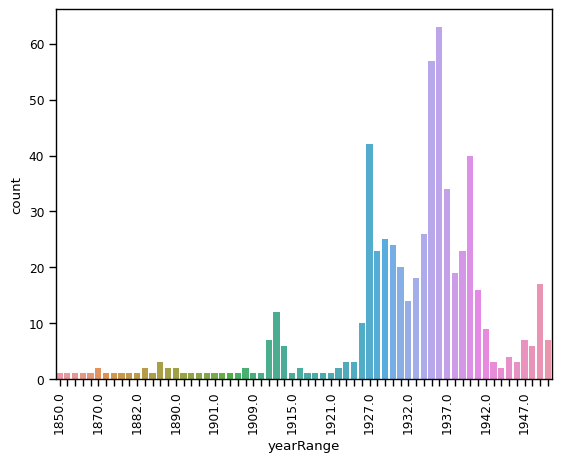

In [33]:
sns.set_context('paper')
sns.countplot(x = 'yearRange', data = filtered_metadata.sort_values(by=['yearRange']))
#plt.title("Count of Newspaper Articles on Women's Suffrage in South Australia from 17 to 19 December 1894", fontsize=13)
plt.xticks(rotation=90)
for ind, label in enumerate(plt.gca().get_xticklabels()):
    if ind % 5 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.show()

In [191]:
top_30_years = filtered_metadata['yearRange'].value_counts().head(20)

print(top_30_years)

yearRange
1936    74
1935    67
1927    47
1940    46
1937    41
1934    39
1939    39
1928    32
1929    31
1933    29
1930    29
1938    29
1931    26
1941    23
1932    21
2004    20
2003    20
1953    19
1952    19
1914    19
Name: count, dtype: int64


In [20]:
magazine_data = pd.read_csv('full-data_chinese-recipe-magazine.csv')

In [23]:
magazine_data['description'] = magazine_data['description'].fillna('NA')

In [47]:
remove_strings = ["Politics and government", "Book industries and trade", "Theater--Australia", ]

# Convert the list of strings into a regex pattern
pattern = '|'.join(remove_strings)

# remove rows in magazine_data['description'] that contains string "Politics and government"
filtered_magazine_data = magazine_data[~magazine_data['description'].str.contains(pattern, case=False)]
# filter for rows in filtered_magazine_data['yearRange'] that is between 1850 and 1950
filtered_magazine_data['yearRange'] = pd.to_numeric(filtered_magazine_data['yearRange'], errors='coerce')

filtered_by_year = filtered_magazine_data[
    (filtered_magazine_data['yearRange'] >= 1850) & 
    (filtered_magazine_data['yearRange'] <= 1950)
]
print(len(filtered_by_year))

556


/var/folders/6l/__m_t5fn1zqgbdwzg0by22400000gn/T/ipykernel_15734/1818148687.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_magazine_data['yearRange'] = pd.to_numeric(filtered_magazine_data['yearRange'], errors='coerce')


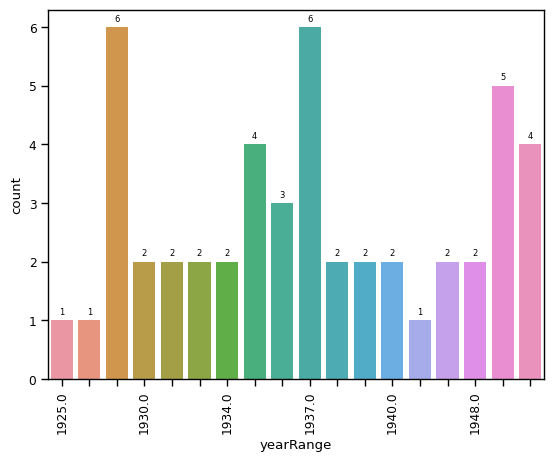

In [120]:
sns.set_context('paper')
ax = sns.countplot(x = 'yearRange', data = selected_rows.sort_values(by=['yearRange']))
plt.xticks(rotation=90)
for ind, label in enumerate(plt.gca().get_xticklabels()):
    if ind % 3 == 0:  # show every 20th label
        label.set_visible(True)
    else:
        label.set_visible(False)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 6), 
                textcoords='offset points',
                fontsize=6)
plt.show()

In [52]:
filtered_by_year.to_csv('magazine-chinese-recipe-desc-filtered_by_year.csv')

In [53]:
tag_counts_multi_split = filtered_by_year['description'].str.split('[;.]').explode().str.strip().value_counts()

In [54]:
pd.set_option('display.max_rows', None)
print(tag_counts_multi_split)

description
                                                                  859
Australian                                                        425
Australasian Radio Relay League--Periodicals                      249
Australia--Social life and customs--Periodicals                   187
Women--Australia--Periodicals                                     161
Australian Broadcasting Commission--Periodicals                    32
Radio programs--Australia--Periodicals                             32
Television programs--Australia--Periodicals                        32
Australia--History--1922-1945--Periodicals                         26
--fast                                                             16
Oceania--Periodicals                                               15
Almanacs, Australian                                               14
W                                                                  13
S                                                                  13
)--Perio

In [114]:
len(filtered_by_year)

498

In [113]:
filtered_by_year.drop([250, 251, 262, 260, 264,265,267,268,277,279,281,286,284], inplace=True)

/var/folders/6l/__m_t5fn1zqgbdwzg0by22400000gn/T/ipykernel_15734/3576844184.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_by_year.drop([250, 251, 262, 260, 264,265,267,268,277,279,281,286,284], inplace=True)


In [112]:
filtered_by_year.loc[277]

Unnamed: 0                                                                   277
id                                                                     233189637
onlineUrl                                   https://nla.gov.au/nla.obj-529753080
title                                   They've All Been Tried! (9 January 1940)
formatDisplay                       Article; Article/Journal or magazine article
yearRange                                                                 1940.0
primaryFormat                                                            Article
description                    Australian; Australia--Social life and customs...
author                                                                       NaN
firstArticlePublicationName                       The Australian woman's mirror.
text                           They've All Been Tried! Pork will be just as c...
fullText                       They've All Been Tried! Pork will be just as c...
Name: 277, dtype: object

In [118]:
desired_indices = list(range(0,284)) + [331,365,366,443]
filtered_indices = list(set(desired_indices) & set(filtered_by_year.index))
selected_rows = filtered_by_year.loc[filtered_indices]

len(selected_rows)

49

In [119]:
selected_rows.to_csv('final-filtered-magazine-chinese-recipes.csv')

## Labeling

In [62]:
newspaper_data = pd.read_csv('manually-selected-newspaper-chinese-recipes.csv', index_col=0)

In [63]:
# add a column of "recipe_type" to newspaper_data
newspaper_data['recipe_type'] = ''
recipe_type_list = [(191, "dahl"), (446, "melon jam"), (1189, "chinese preserved ginger"), (1289, "chinese preserved melon"), (1371,"chinese preserved egg"), (1511,"chinese preserved egg"),
                    (1796, "chinese baked pudding dessert"), (1873, "dried preserved oysters"), (1970,"chinese rice pudding dessert"), (2778, "chinese toast"), 
                    (2975, "chinese cookies dessert"), (3261,"gingembre a la chantilly"), (3992,"chinese drink"), (4061,"spanish rice"), (5751,"chinese veal"),
                    (5759,"chinese pie pastry"), (5776,"chinese potatoes"), (5781, "chinese flaky pastry"), (5799,"chinese chews dessert"),(5809,"chinese veal"), 
                    (5828, "chinese strips dessert"), (5858,"chinese melon jam preserved melon"), (5868,"chop suey"), (5879,"chinese chews dessert"), (5894,"chinese chews dessert"),
                    (5905, "chinese pudding dessert"), (5936,"dim sims"), (5981,"chinese almond wafers blanch dessert"), (5989,"rice; savory rice curried"), (6014,"chinese chews dessert"), (6023,"chinese stuffed fish"),
                    (6034, "chinese cake dessert"), (6054, "chow mein"), (6097, "chinese mustard pickle"), (6099,"chinese mustard pickle"), (6100,"chinese mustard pickle"), (6101,"chinese mustard pickle"), (6102,"chinese mustard pickle"),
                    (6103, "chinese mustard pickle"), (6104,"chinese mustard pickle"), (6105,"chinese mustard pickle"), (6106,"chinese mustard pickle"), (6108,"chinese mustard pickle"), (6109,"chinese mustard pickle"), (6123,"chinese mustard pickle"),
                    (6143, "chinese tea cakes dessert"), (6160,"chinese chews dessert"), (6176, "meat dumplings; stuffed squash; pork chops and chinese sauce; chinese peanut brittle dessert"), (6190,"pansit"), (6198,"chinese cooler drink"), (6206,"chinese mustard pickle"),
                    (6216, "chinese mustard pickle"), (6218,"chinese mustard pickle"), (6220,"chinese omelette"), (6277,"meat dumplings; stuffed squash; pork chops and chinese sauce; chinese peanut brittle dessert; chicken with mushrooms; persimmon salad; fried fish; stuffed mushrooms; peking wall; marrow bone soup; cornmeal cakes with dates dessert; mahjong biscuits dessert"),
                    (6307, "roased peaches dessert"), (6309,"chinese almond cake dessert"), (6311,"chop suey"), (6316,"rosed peaches dessert"), (6317,"rosed peaches dessert"), (6325,"rosed peaches dessert"), (6330,"rosed peaches dessert"), (6336,"chinese almond cake dessert"), (6401, "chinese tea cakes dessert"), (6409,"chinese tea cakes dessert"),
                    (6409, "chinese soup"), (6449, "rosed peaches dessert"), (6473, "chinese veal"), (6481,"rosed peaches dessert"), (6624,"chinese tea cakes dessert"), (6629,"chinese tea cakes dessert"), (6630,"chinese tea cakes dessert"), (6636,"chinese tea cakes dessert"),
                    (6701, "rosed peaches dessert"), (6862,"chinese tea cakes dessert"), (6867,"chicken with mushrooms; (persimmon salad); fried fish; (stuffed mushrooms); peking wall; marrow bone soup"), (7850, "chinese chews dessert"), (7854,"chinese soup"), 
                    (7855, "chinese kedgeree"), (7857, "chinese cabbage au gratin"), (7858, "chinese kedgeree"), (7867, "chinese chutney"), (7881, "chinese eggs"), (7882, "chop suey"), (7921, "chinese veal"),
                    (7927, "chinese eggs"), (7929, "chinese mustard pickle"), (7933, "chinese chews dessert"), (7971, "chinese oysters"), (7972, "chinese cutlets"), (8022, "chinese broth"), (8034, "chinese chews dessert"), (8065, "chinese chews dessert"), (8069, "eggs in chinese sauce"), (8136, "chinese chews dessert"), (8184, "chinese asparagus puffs pastry"), (8236, "sorrel soup")]

In [64]:
for i in range(len(recipe_type_list)):
    newspaper_data.loc[recipe_type_list[i][0], 'recipe_type'] = recipe_type_list[i][1]

In [65]:
# drop irrelevant entries
filtered_df = newspaper_data.drop([2801, 6065, 6087])
filtered_df.to_csv('manually-selected-newspaper-chinese-recipes-labelled.csv')

## Count Frequency of recipes

In [16]:
#newspaper_data[newspaper_data['recipe_type'].isna()]
newspaper_data = pd.read_csv('manually-selected-newspaper-chinese-recipes-labelled.csv', index_col=0)

In [70]:
newspaper_data.columns

Index(['Unnamed: 0', 'id', 'title', 'abstrct', 'snippets', 'formatDisplay',
       'newspaper', 'date', 'articleType', 'wordCount', 'onlineUrl',
       'description', 'illustrated', 'cleanedSnip', 'cleanedAbstract',
       'cleanedTitle', 'combined_text', 'cluster', 'text', 'cleanedText',
       'year', 'recipe_type'],
      dtype='object')

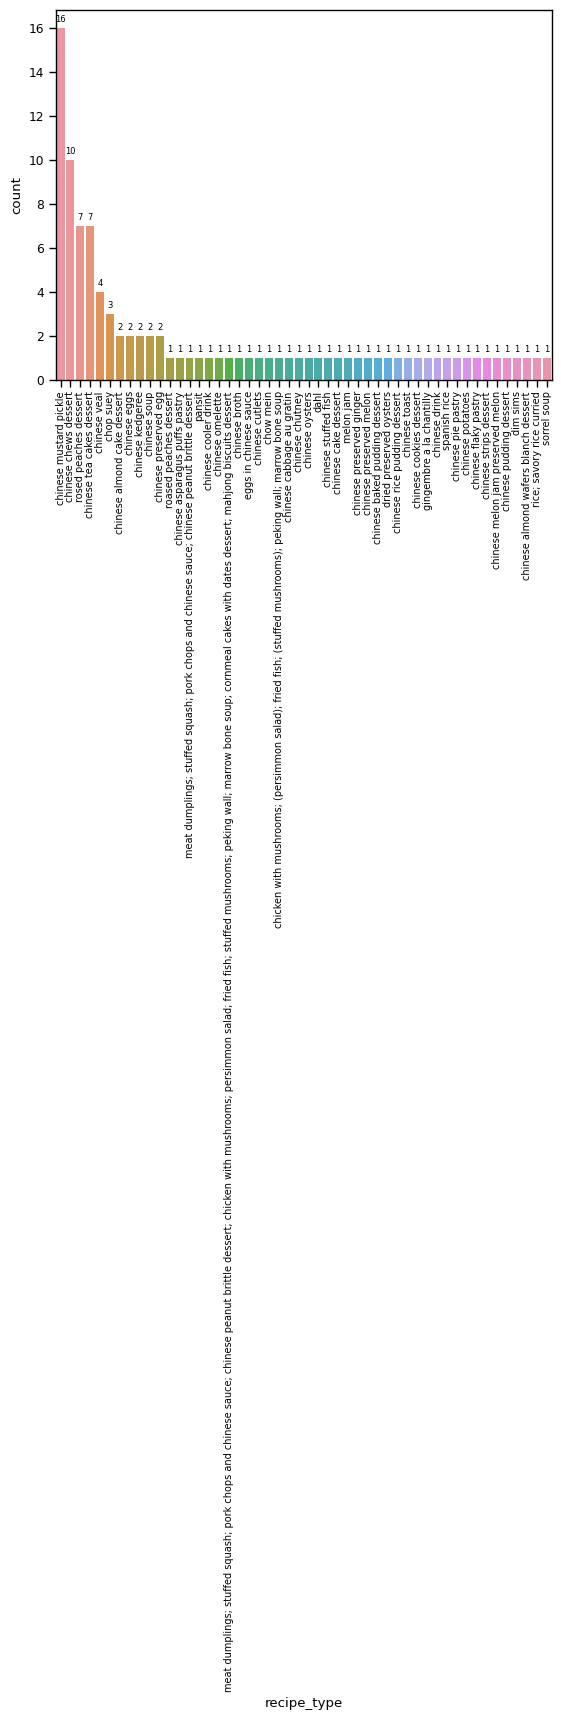

In [29]:
def plot_top_recipes_trend(dataframe, recipe_col='recipe_type', year_col='year', top_n=11):
    
    # 1. Identify the Top N Recipes
    top_recipes = dataframe[recipe_col].value_counts().head(top_n).index.tolist()

    # 2. Filter Data
    filtered_df = dataframe[dataframe[recipe_col].isin(top_recipes)]

    # 3. Pivot and Aggregate Data
    pivot_df = filtered_df.groupby([year_col, recipe_col]).size().unstack()

    # 4. Visualization
    plt.figure(figsize=(15, 7))
    for column in pivot_df.columns:
        plt.scatter(pivot_df.index, pivot_df[column], label=column)

    plt.title(f'Popularity Trend of Top {top_n} Recipes Over the Years')
    plt.xlabel('Year')
    plt.ylabel('Number of Times Accessed/Made')
    plt.legend()
    plt.grid(True)
    plt.show()


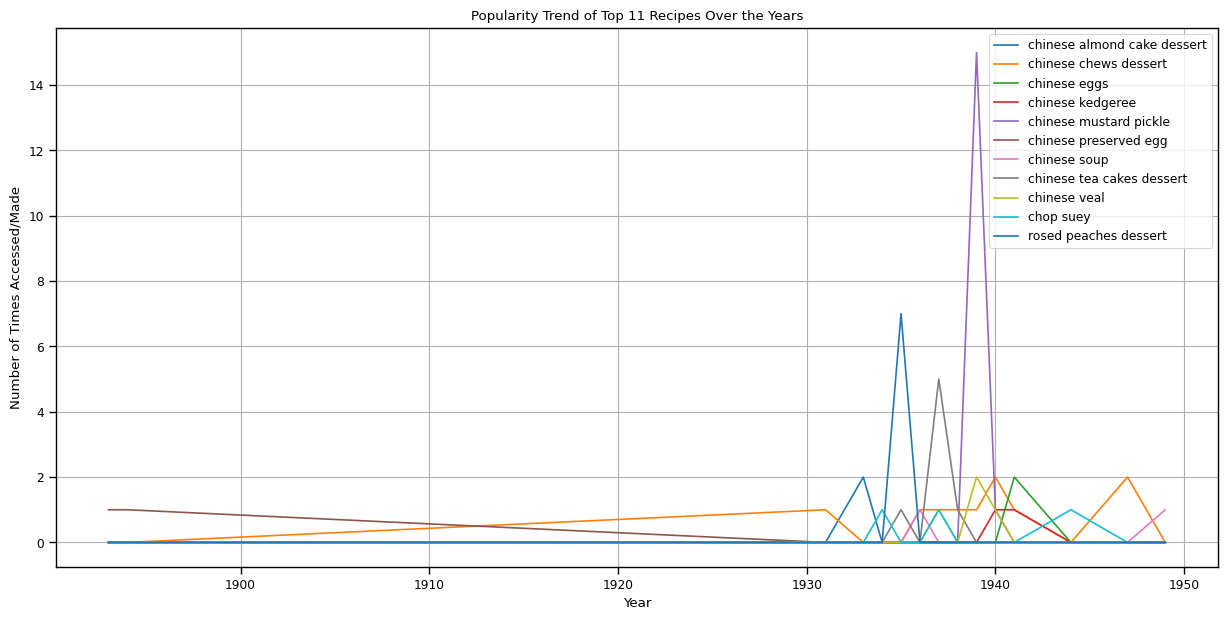

In [76]:
plot_top_recipes_trend(newspaper_data)

In [15]:
mag_data = pd.read_csv('final-filtered-magazine-chinese-recipes-labeled.csv', index_col=1)

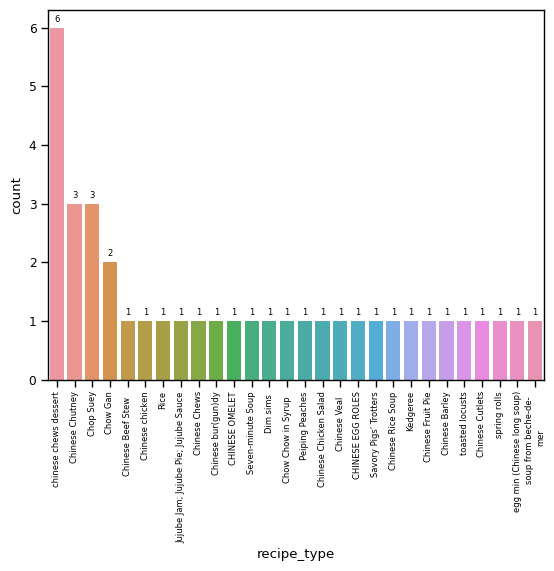

In [17]:
order = mag_data['recipe_type'].value_counts().index
sns.set_context('paper')
ax = sns.countplot(x = 'recipe_type', data = mag_data, order=order)
plt.xticks(rotation=90, fontsize=6)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 6), 
                textcoords='offset points',
                fontsize=6)

In [78]:
mag_data.columns

Index(['recipe_type', 'Unnamed: 0', 'id', 'onlineUrl', 'title',
       'formatDisplay', 'yearRange', 'primaryFormat', 'description', 'author',
       'firstArticlePublicationName', 'text', 'fullText'],
      dtype='object')

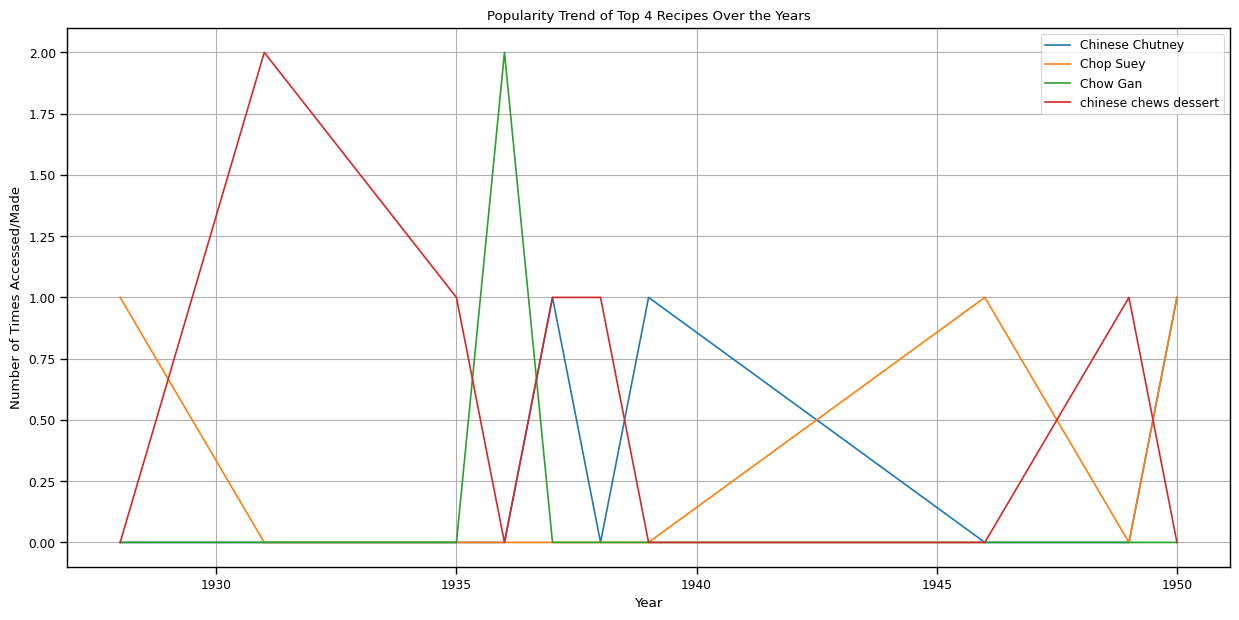

In [79]:
plot_top_recipes_trend(mag_data, year_col="yearRange", top_n=4)

In [17]:
newspaper_expanded = (newspaper_data.set_index(newspaper_data.columns.drop('recipe_type', 1).tolist())
      .recipe_type.str.split(';', expand=True)
      .stack()
      .reset_index()
      .rename(columns={0: 'recipe_type'})
      .loc[:, newspaper_data.columns]
)


In [18]:
newspaper_expanded['category'] = 'dish'
newspaper_expanded.loc[newspaper_expanded['recipe_type'].str.contains('preserved|pickle', case=False, na=False), 'category'] = 'preservation'
newspaper_expanded.loc[newspaper_expanded['recipe_type'].str.contains('drink', case=False, na=False), 'category'] = 'drink'
newspaper_expanded.loc[newspaper_expanded['recipe_type'].str.contains('dessert|pastry', case=False, na=False, regex=True), 'category'] = 'dessert or pastry'

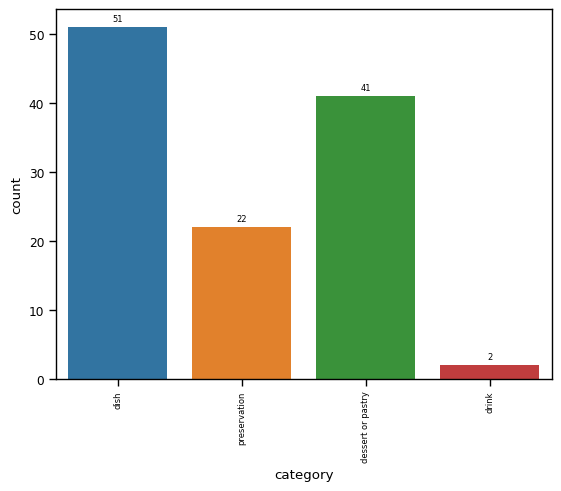

In [19]:

sns.set_context('paper')
ax = sns.countplot(x = 'category', data = newspaper_expanded)
plt.xticks(rotation=90, fontsize=6)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 6), 
                textcoords='offset points',
                fontsize=6)

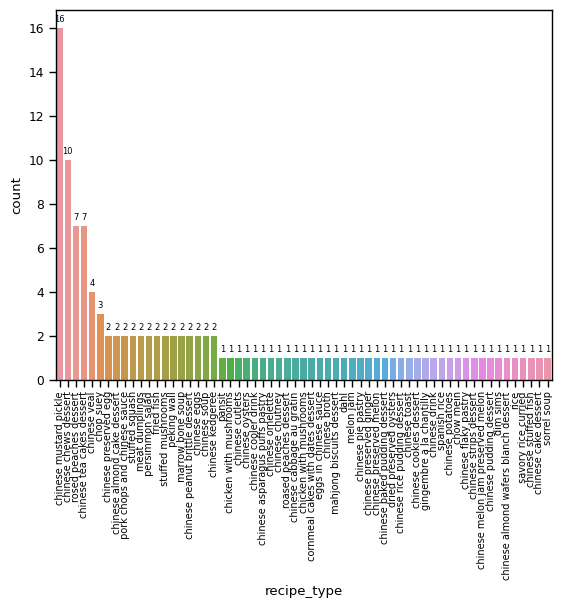

In [21]:
newspaper_expanded['recipe_type'] = newspaper_expanded['recipe_type'].apply(lambda x: re.sub(r"[^\w\s]", '', x))
order = newspaper_expanded['recipe_type'].value_counts().index
sns.set_context('paper')
ax = sns.countplot(x = 'recipe_type', data = newspaper_expanded, order=order)
plt.xticks(rotation=90, fontsize=7)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 6), 
                textcoords='offset points',
                fontsize=6)
plt.show()

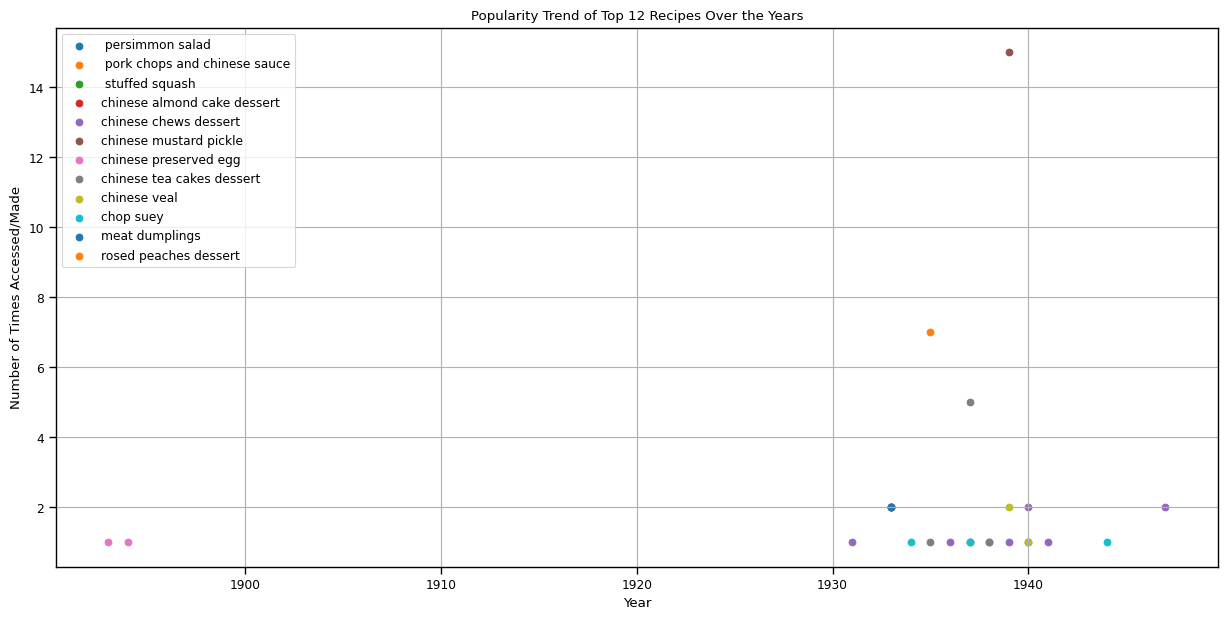

In [32]:
plot_top_recipes_trend(newspaper_expanded, top_n=12)

In [54]:
chosen_recipe_list_newspaper =['chinese mustard pickle', 'chinese preserved egg', 'chinese chews dessert','chinese tea cakes dessert', 'rosed peaches dessert', 
                     'chinese veal', 'chop suey', 'dim sims', 'dahl', 'chinese preserved melon', 'melon jam', 'gingembre a la chantilly', 'sorrel soup']
chosen_recipe_list_mag = ['chow gan', 'chinese chutney', 'dim sims', 'chinese chews dessert']

In [58]:
def plot_chosen_recipes_scatter(dataframe, recipe_col='recipe_type', year_col='year', chosen_list=[]):    
    # 1. Filter Data
    dataframe[recipe_col] = dataframe[recipe_col].str.strip().str.lower()
    filtered_df = dataframe[dataframe[recipe_col].isin(chosen_list)]

    # 2. Visualization
    plt.figure(figsize=(15, 7))
    
    # Generate a list of colors from seaborn's color palette
    colors = sns.color_palette("husl", len(chosen_list))
    
    # Dictionary to map recipes to y-values
    recipe_to_y = {recipe: idx for idx, recipe in enumerate(chosen_list)}
    
    for idx, recipe in enumerate(chosen_list):
        subset = filtered_df[filtered_df[recipe_col] == recipe]
        plt.scatter(subset[year_col], [recipe_to_y[recipe]]*len(subset), label=recipe, color=colors[idx])

    plt.yticks(list(recipe_to_y.values()), list(recipe_to_y.keys()))
    plt.title(f'Scatter Plot of Selected Recipes Over the Years')
    plt.xlabel('Year')
    plt.ylabel('Recipe Type')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()


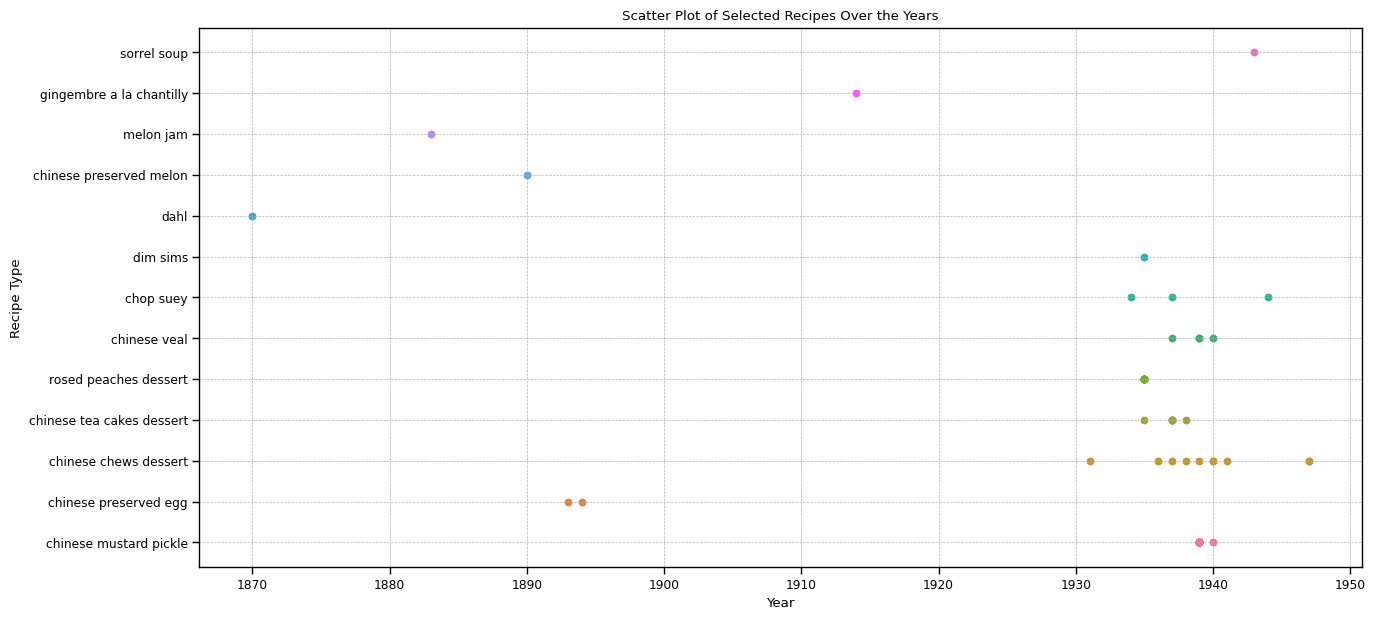

In [59]:
plot_chosen_recipes_scatter(newspaper_expanded, chosen_list=chosen_recipe_list_newspaper)

/var/folders/6l/__m_t5fn1zqgbdwzg0by22400000gn/T/ipykernel_93443/815697751.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['frequency'] = filtered_df.groupby(['year', 'recipe_type'])['recipe_type'].transform('count')


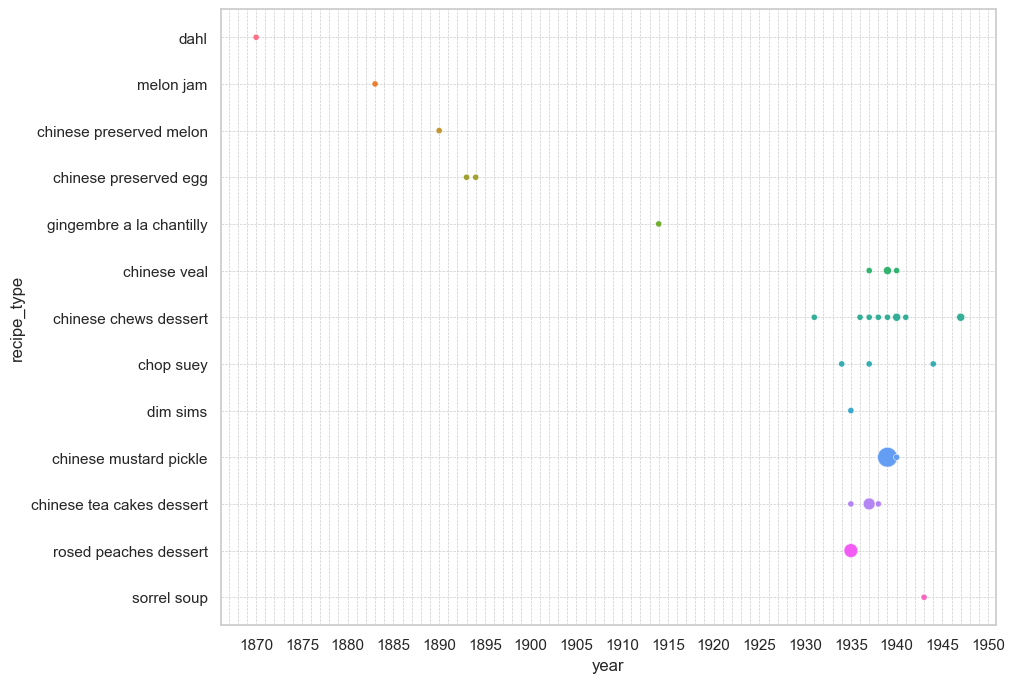

In [84]:
sns.set_context('paper')
sns.set_theme(style="whitegrid")
filtered_df = newspaper_expanded[newspaper_expanded['recipe_type'].isin(chosen_recipe_list_newspaper)]

# Compute the frequency for each combination of 'year' and 'recipe_type' in the filtered dataframe
filtered_df['frequency'] = filtered_df.groupby(['year', 'recipe_type'])['recipe_type'].transform('count')

from matplotlib.ticker import MultipleLocator


plt.figure(figsize=(10, 8))
ax = sns.scatterplot(data=filtered_df, x='year', y='recipe_type', hue='recipe_type', size='frequency', palette='husl', sizes=(20, 200), legend=False)

# Set major and minor ticks for the x-axis
ax.xaxis.set_major_locator(MultipleLocator(5))  # Adjust as needed for major ticks
ax.xaxis.set_minor_locator(MultipleLocator(1))  # Adjust as needed for minor ticks

# Display the grid for both major and minor ticks
ax.grid(which='both', linestyle='--', linewidth=0.5)

plt.show()

In [69]:
len(newspaper_expanded)

116

In [89]:
tqdm.pandas()
filtered_df['new_text'] = filtered_df['id'].progress_apply(extract_text)

  0%|          | 0/55 [00:00<?, ?it/s]

/var/folders/6l/__m_t5fn1zqgbdwzg0by22400000gn/T/ipykernel_93443/3902113047.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['new_text'] = filtered_df['id'].progress_apply(extract_text)


In [92]:
selected_columns = filtered_df.iloc[:, list(range(1, 5)) + list(range(6, 8)) + [17] + list(range(20, 25))]


In [95]:
selected_columns.to_csv('selected-prototype-newspaper-recipes.csv')